## Binary Classification: Gender classifier data
https://www.crowdflower.com/data-for-everyone/

** Dataset Information: **

- 20,000 images from Twitter profile

** Attribute Information: **

- color images

** Objective of this project **

- judge whether the user was a male or a female

## Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

Using TensorFlow backend.


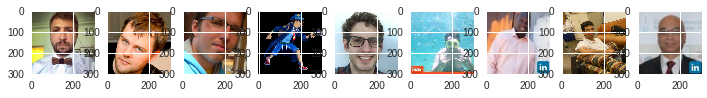

In [5]:
filepath = 'drive/app/gender/'
# plot the first 9 males
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/male/'+os.listdir(filepath+'train_set/male/')[i]))

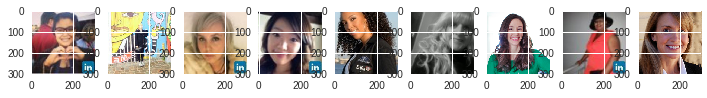

In [0]:
# plot the first 9 female
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/female/'+os.listdir(filepath+'train_set/female/')[i]))

## Data preprocessing

In [11]:
# Generate minibatches of image data with real-time data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# read image data
batch_size = 32

train_set = train_datagen.flow_from_directory(filepath+'train_set',
                                              target_size = (128,128),
                                              batch_size = batch_size,
                                              class_mode = 'binary')

test_set = test_datagen.flow_from_directory(filepath+'test_set',
                                            target_size = (128, 128),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [4]:
train_set.class_indices

{'female': 0, 'male': 1}

In [5]:
train_set.data_format

'channels_last'

In [6]:
train_set.image_shape

(128, 128, 3)

# Model: vgg16+dense

#### Train the Network

In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
import keras.backend as K

seed = 123
np.random.seed(seed)
K.clear_session()
epochs = 100
filepath_model = filepath+'weights_best_model.hdf5'

# pretrained vgg16 model
base_model = applications.VGG16(include_top=False, weights='imagenet',
                               input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

# add top layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [18]:
# callbacks
early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='max')
checkpoint = ModelCheckpoint(filepath_model, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint, early_stop]

# train the model
model.fit_generator(train_set, 
                    steps_per_epoch = 11663 // batch_size, 
                    epochs = epochs, 
                    validation_data = test_set, 
                    validation_steps = 2920 // batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
364/364 [==============================] - 145s 397ms/step - loss: 0.2263 - acc: 0.9013 - val_loss: 0.3466 - val_acc: 0.8640

Epoch 00001: val_acc improved from -inf to 0.86401, saving model to drive/app/gender/weights_best_model.hdf5
Epoch 2/100
194/364 [==============>...............] - ETA: 59s - loss: 0.2310 - acc: 0.9009364/364 [==============================] - 144s 397ms/step - loss: 0.2236 - acc: 0.9053 - val_loss: 0.3586 - val_acc: 0.8544

Epoch 00002: val_acc did not improve
Epoch 3/100
337/364 [==========================>...] - ETA: 9s - loss: 0.2187 - acc: 0.9061364/364 [==============================] - 144s 395ms/step - loss: 0.2172 - acc: 0.9065 - val_loss: 0.3810 - val_acc: 0.8589

Epoch 00003: val_acc did not improve
Epoch 4/100
364/364 [==============================] - 143s 393ms/step - loss: 0.2161 - acc: 0.9037 - val_loss: 0.3718 - val_acc: 0.8620

Epoch 00004: val_acc did not improve
Epoch 5/100
 10/364 [..............................] - ETA: 1:29 - lo

#### Evaluate the Network

In [19]:
from itertools import islice
X_test = []
y_test = []
for ts in islice(test_set, round(2920/32)):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
X_test.shape,y_test.shape

((2888, 128, 128, 3), (2888,))

Accuracy:	86.4%
roc auc:	0.865


             precision    recall  f1-score   support

        0.0       0.89      0.84      0.86      1478
        1.0       0.84      0.89      0.86      1410

avg / total       0.87      0.86      0.86      2888



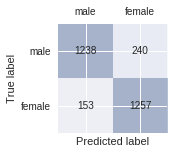

In [22]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
# predict class with test set
model.load_weights(filepath_model)
y_pred_test =  model.predict(X_test)>0.5
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))
print('roc auc:\t{:0.3f}'.format(roc_auc_score(y_test,y_pred_test)))

#classification report
print('\n')
print(classification_report(y_test, y_pred_test))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xticks((0,1),('male', 'female'))
plt.yticks((0,1),('male', 'female'))    
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

#### Predict new images

In [0]:
def male_or_female(filename):    
    test_image = image.load_img(filepath+'prediction/'+filename, target_size = (128, 128))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        return 'male'
    else:
        return 'female'

'female'

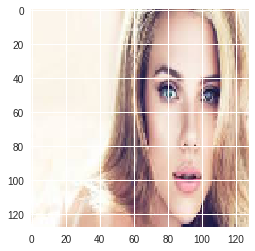

In [24]:
male_or_female('male_or_female1.jpg')

'male'

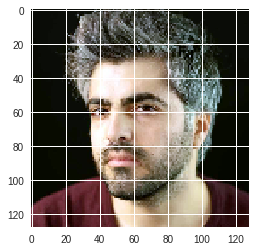

In [25]:
male_or_female('male_or_female2.jpg')

'male'

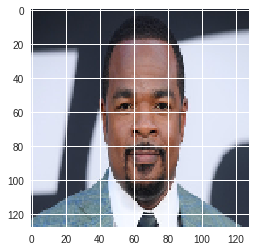

In [26]:
male_or_female('male_or_female3.jpg')

'female'

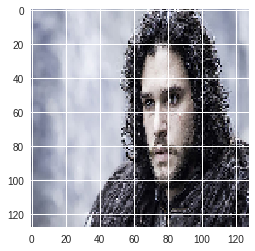

In [27]:
male_or_female('male_or_female4.jpg')